# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

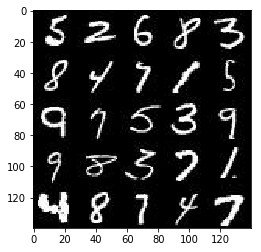

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

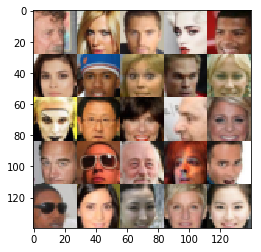

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/home/jsanchezrodr/myprojects/udacity_deep_learning/env/lib/python3.4/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    image = tf.placeholder(shape=[None,image_width, image_height, image_channels], dtype=tf.float32)
    z_input = tf.placeholder(shape=[None, z_dim], dtype=tf.float32)
    
    learning_rate = tf.placeholder(dtype=tf.float32)
    
    return image, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.4/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/jsanchezrodr/myprojects/udacity_deep_learning/env/lib/python3.4/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/jsanchezrodr/myprojects/udacity_deep_learning/env/lib/python3.4/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/jsanchezrodr/myprojects/udacity_deep_learning/env/lib/python3.4/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/h

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        
        conv1 = tf.layers.conv2d(
            inputs=images,
            filters=20,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.elu)
        
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        
        bn1 = tf.layers.batch_normalization(pool1, training=True)
        
        
        
        conv2 = tf.layers.conv2d(
            inputs=bn1,
            filters=40,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.elu)
        
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        
        bn2 = tf.layers.batch_normalization(pool2, training=True)
        
        
        conv3 = tf.layers.conv2d(
            inputs=bn2,
            filters=60,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.elu)
        
        pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
        
        bn3 = tf.layers.batch_normalization(pool3, training=True)
        
        a,b,c,d = bn3.get_shape()
        
        dense_input = tf.reshape(bn3, [-1,int(b*c*d)])
        logits = tf.layers.dense(dense_input,1,activation=None)
        
        output = tf.nn.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope("generator", reuse=not is_train):
        
        
        dense1 = tf.layers.dense(z, 60*7*7, tf.nn.elu)
        
        
        dense1_block = tf.reshape(dense1, [-1,7,7,60])
        
        dense_bn = tf.layers.batch_normalization(dense1_block, training=is_train)
        
        convt1 = tf.layers.conv2d_transpose(
            inputs=dense_bn,
            filters=40,
            kernel_size=[5,5],
            strides=1,
            padding="same",
            activation=tf.nn.elu
        )
        
        convt1_bn = tf.layers.batch_normalization(convt1, training=is_train)
        
        
        convt2 = tf.layers.conv2d_transpose(
            inputs=convt1_bn,
            filters=20,
            kernel_size=[5,5],
            strides=2,
            padding="same",
            activation=tf.nn.elu
        )
        
        convt2_bn = tf.layers.batch_normalization(convt2, training=is_train)
        
        
        convt3 = tf.layers.conv2d_transpose(
            inputs=convt2_bn,
            filters=out_channel_dim,
            kernel_size=[5,5],
            strides=2,
            padding="same",
            activation=tf.nn.tanh,
        )
        
    
    return convt3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    
    output_real, logits_real = discriminator(input_real, reuse=False)    
    
    input_fake = generator(input_z, out_channel_dim, is_train=True) # reuse=False
    output_fake, logits_fake = discriminator(input_fake, reuse=True)
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(output_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(output_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(output_fake)))

    return d_loss, g_loss
    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    #From DCGAN
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    #print(beta1)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
import matplotlib.pyplot as plt
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    data_size,image_width,image_height,image_channels =  data_shape
    image_placeholder, z_placeholder, lr_placeholder = model_inputs(image_width, image_height,image_channels, z_dim)
    
    n_images_show =25
    show_every=100
    print_every = 10
    
    
    d_loss, g_loss = model_loss(image_placeholder, z_placeholder,image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_placeholder, beta1)
    
    losses = []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                
                

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={
                    image_placeholder: batch_images, 
                    z_placeholder: batch_z,
                    lr_placeholder:learning_rate
                })
                
                _ = sess.run(g_train_opt, feed_dict={
                    image_placeholder: batch_images,
                    z_placeholder: batch_z,
                    lr_placeholder:learning_rate
                })

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({
                        z_placeholder: batch_z, 
                        image_placeholder: batch_images,
                        lr_placeholder:learning_rate
                    })
                    train_loss_g = g_loss.eval({
                        z_placeholder: batch_z,
                        lr_placeholder:learning_rate,
                        image_placeholder: batch_images,
                    })

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if(steps%show_every == 0):
                    show_generator_output(sess,n_images_show,z_placeholder,image_channels,data_image_mode)
                steps += 1

        show_generator_output(sess,n_images_show,z_placeholder,image_channels,data_image_mode)
        fig, ax = plt.subplots()
        losses = np.array(losses)
        plt.plot(losses.T[0], label='Discriminator')
        plt.plot(losses.T[1], label='Generator')
        plt.title("Training Losses")
        plt.legend()
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.9964... Generator Loss: 0.0957


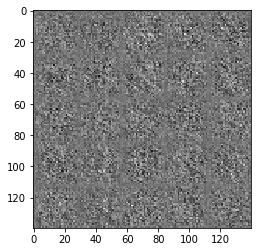

Epoch 1/2... Discriminator Loss: 0.8033... Generator Loss: 1.2389
Epoch 1/2... Discriminator Loss: 0.3105... Generator Loss: 1.9125
Epoch 1/2... Discriminator Loss: 0.1050... Generator Loss: 3.0465
Epoch 1/2... Discriminator Loss: 0.3261... Generator Loss: 1.9433
Epoch 1/2... Discriminator Loss: 0.2613... Generator Loss: 2.1338
Epoch 1/2... Discriminator Loss: 0.2753... Generator Loss: 2.1183
Epoch 1/2... Discriminator Loss: 2.1609... Generator Loss: 0.3512
Epoch 1/2... Discriminator Loss: 0.3123... Generator Loss: 2.1508
Epoch 1/2... Discriminator Loss: 0.2934... Generator Loss: 2.1063
Epoch 1/2... Discriminator Loss: 7.0993... Generator Loss: 9.5649


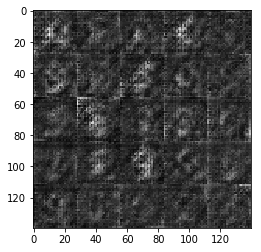

Epoch 1/2... Discriminator Loss: 0.5164... Generator Loss: 2.1086
Epoch 1/2... Discriminator Loss: 0.4871... Generator Loss: 1.6505
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 1.9595
Epoch 1/2... Discriminator Loss: 0.4996... Generator Loss: 2.3723
Epoch 1/2... Discriminator Loss: 0.3895... Generator Loss: 2.5446
Epoch 1/2... Discriminator Loss: 0.4224... Generator Loss: 1.6461
Epoch 1/2... Discriminator Loss: 0.4472... Generator Loss: 2.3077
Epoch 1/2... Discriminator Loss: 0.5299... Generator Loss: 1.3608
Epoch 1/2... Discriminator Loss: 0.4822... Generator Loss: 1.3918
Epoch 1/2... Discriminator Loss: 0.3213... Generator Loss: 1.8419


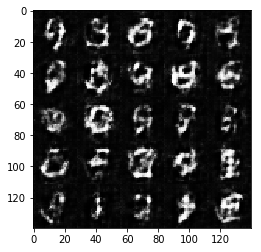

Epoch 1/2... Discriminator Loss: 0.3574... Generator Loss: 1.7983
Epoch 1/2... Discriminator Loss: 0.3420... Generator Loss: 2.5841
Epoch 1/2... Discriminator Loss: 0.3699... Generator Loss: 2.3445
Epoch 1/2... Discriminator Loss: 0.2670... Generator Loss: 2.3790
Epoch 1/2... Discriminator Loss: 0.4051... Generator Loss: 3.3995
Epoch 1/2... Discriminator Loss: 0.4017... Generator Loss: 1.7062
Epoch 1/2... Discriminator Loss: 0.3515... Generator Loss: 1.8085
Epoch 1/2... Discriminator Loss: 0.7431... Generator Loss: 0.9195
Epoch 1/2... Discriminator Loss: 0.4250... Generator Loss: 1.4895
Epoch 1/2... Discriminator Loss: 0.4031... Generator Loss: 1.5840


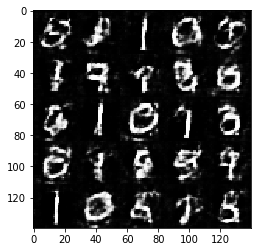

Epoch 1/2... Discriminator Loss: 0.3291... Generator Loss: 1.9132
Epoch 1/2... Discriminator Loss: 0.2685... Generator Loss: 2.2122
Epoch 1/2... Discriminator Loss: 0.3592... Generator Loss: 2.4157
Epoch 1/2... Discriminator Loss: 0.3678... Generator Loss: 1.8837
Epoch 1/2... Discriminator Loss: 0.2942... Generator Loss: 2.4168
Epoch 1/2... Discriminator Loss: 0.2912... Generator Loss: 2.1217
Epoch 1/2... Discriminator Loss: 0.3622... Generator Loss: 2.3207
Epoch 1/2... Discriminator Loss: 0.2355... Generator Loss: 2.9747
Epoch 1/2... Discriminator Loss: 0.3380... Generator Loss: 1.7124
Epoch 1/2... Discriminator Loss: 0.3722... Generator Loss: 1.6389


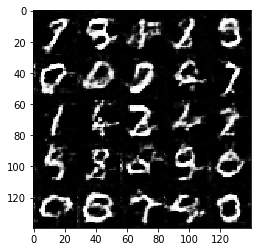

Epoch 1/2... Discriminator Loss: 0.8478... Generator Loss: 0.7322
Epoch 1/2... Discriminator Loss: 0.2676... Generator Loss: 2.3050
Epoch 1/2... Discriminator Loss: 0.3452... Generator Loss: 1.8542
Epoch 1/2... Discriminator Loss: 0.2392... Generator Loss: 2.1217
Epoch 1/2... Discriminator Loss: 0.1429... Generator Loss: 2.7926
Epoch 1/2... Discriminator Loss: 0.1290... Generator Loss: 3.0161
Epoch 2/2... Discriminator Loss: 0.3513... Generator Loss: 1.7002
Epoch 2/2... Discriminator Loss: 0.2145... Generator Loss: 2.7581
Epoch 2/2... Discriminator Loss: 0.2131... Generator Loss: 2.8795
Epoch 2/2... Discriminator Loss: 0.1856... Generator Loss: 2.5670


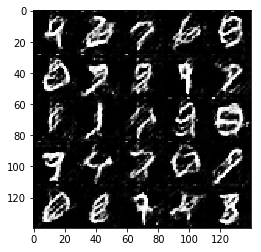

Epoch 2/2... Discriminator Loss: 0.1237... Generator Loss: 2.8955
Epoch 2/2... Discriminator Loss: 0.1417... Generator Loss: 3.0643
Epoch 2/2... Discriminator Loss: 0.1615... Generator Loss: 2.6691
Epoch 2/2... Discriminator Loss: 0.1319... Generator Loss: 2.8779
Epoch 2/2... Discriminator Loss: 0.1088... Generator Loss: 3.2980
Epoch 2/2... Discriminator Loss: 0.0962... Generator Loss: 3.3090
Epoch 2/2... Discriminator Loss: 0.1055... Generator Loss: 3.0207
Epoch 2/2... Discriminator Loss: 0.0766... Generator Loss: 3.7174
Epoch 2/2... Discriminator Loss: 0.0741... Generator Loss: 3.3631
Epoch 2/2... Discriminator Loss: 0.0812... Generator Loss: 3.4390


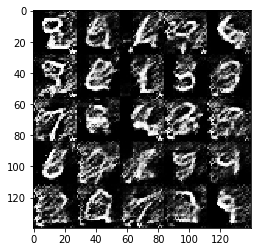

Epoch 2/2... Discriminator Loss: 0.0770... Generator Loss: 3.7035
Epoch 2/2... Discriminator Loss: 0.0712... Generator Loss: 3.9521
Epoch 2/2... Discriminator Loss: 0.0587... Generator Loss: 3.9720
Epoch 2/2... Discriminator Loss: 0.0654... Generator Loss: 3.6186
Epoch 2/2... Discriminator Loss: 0.0583... Generator Loss: 3.6002
Epoch 2/2... Discriminator Loss: 0.0699... Generator Loss: 3.5807
Epoch 2/2... Discriminator Loss: 0.0653... Generator Loss: 3.6557
Epoch 2/2... Discriminator Loss: 0.0478... Generator Loss: 3.8227
Epoch 2/2... Discriminator Loss: 0.0617... Generator Loss: 3.4789
Epoch 2/2... Discriminator Loss: 0.0161... Generator Loss: 4.6687


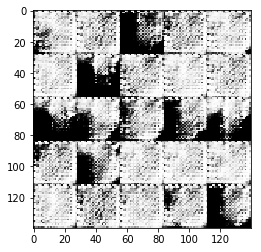

Epoch 2/2... Discriminator Loss: 0.0536... Generator Loss: 3.5591
Epoch 2/2... Discriminator Loss: 0.0282... Generator Loss: 3.9951
Epoch 2/2... Discriminator Loss: 0.0370... Generator Loss: 3.6982
Epoch 2/2... Discriminator Loss: 0.0513... Generator Loss: 3.4168
Epoch 2/2... Discriminator Loss: 0.0416... Generator Loss: 3.4707
Epoch 2/2... Discriminator Loss: 0.0388... Generator Loss: 3.7130
Epoch 2/2... Discriminator Loss: 0.0182... Generator Loss: 4.2640
Epoch 2/2... Discriminator Loss: 0.0268... Generator Loss: 3.9831
Epoch 2/2... Discriminator Loss: 0.0232... Generator Loss: 4.1102
Epoch 2/2... Discriminator Loss: 0.0116... Generator Loss: 4.8090


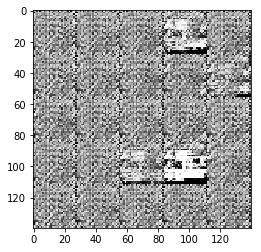

Epoch 2/2... Discriminator Loss: 0.0194... Generator Loss: 4.2544
Epoch 2/2... Discriminator Loss: 0.0132... Generator Loss: 4.7751
Epoch 2/2... Discriminator Loss: 0.0103... Generator Loss: 4.8889
Epoch 2/2... Discriminator Loss: 0.0241... Generator Loss: 4.0713
Epoch 2/2... Discriminator Loss: 0.0167... Generator Loss: 4.5689
Epoch 2/2... Discriminator Loss: 0.0131... Generator Loss: 4.7036
Epoch 2/2... Discriminator Loss: 0.0213... Generator Loss: 4.1661
Epoch 2/2... Discriminator Loss: 0.0228... Generator Loss: 3.9634
Epoch 2/2... Discriminator Loss: 0.0103... Generator Loss: 4.8181
Epoch 2/2... Discriminator Loss: 0.0056... Generator Loss: 5.7275


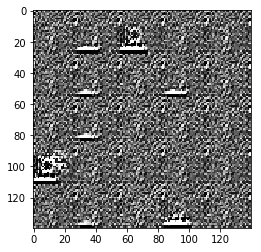

Epoch 2/2... Discriminator Loss: 0.0069... Generator Loss: 5.8415
Epoch 2/2... Discriminator Loss: 0.0147... Generator Loss: 4.7734
Epoch 2/2... Discriminator Loss: 4.8231... Generator Loss: 19.1259


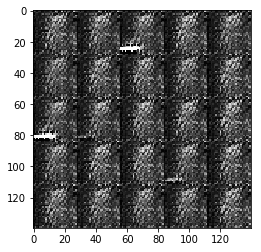

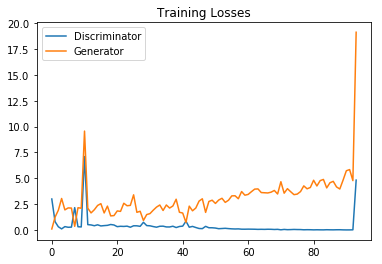

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 1e-3
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.9087... Generator Loss: 0.0363


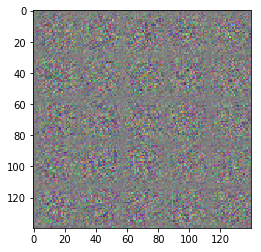

Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 1.5830
Epoch 1/1... Discriminator Loss: 0.4258... Generator Loss: 2.0791
Epoch 1/1... Discriminator Loss: 0.2931... Generator Loss: 2.7669
Epoch 1/1... Discriminator Loss: 0.0893... Generator Loss: 3.4048
Epoch 1/1... Discriminator Loss: 0.2212... Generator Loss: 2.1331
Epoch 1/1... Discriminator Loss: 0.4646... Generator Loss: 1.8626
Epoch 1/1... Discriminator Loss: 0.3067... Generator Loss: 2.0742
Epoch 1/1... Discriminator Loss: 1.7677... Generator Loss: 3.3482
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 2.2178


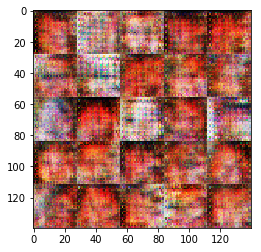

Epoch 1/1... Discriminator Loss: 0.5348... Generator Loss: 1.7127
Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 2.1023
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.7866
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 2.2977
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.6459


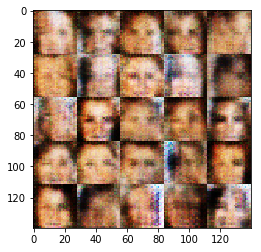

Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.0706
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.7207
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 1.3410
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 0.7676


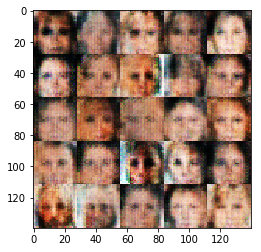

Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 0.4629... Generator Loss: 1.6612
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 0.7968... Generator Loss: 3.7033
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 1.4604
Epoch 1/1... Discriminator Loss: 0.2566... Generator Loss: 2.9032
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.6663... Generator Loss: 0.3052
Epoch 1/1... Discriminator Loss: 0.5502... Generator Loss: 1.7883
Epoch 1/1... Discriminator Loss: 0.4523... Generator Loss: 1.4542


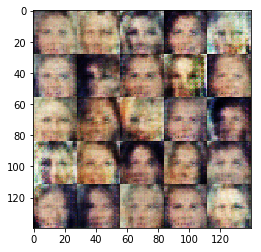

Epoch 1/1... Discriminator Loss: 0.4725... Generator Loss: 1.5310
Epoch 1/1... Discriminator Loss: 3.8942... Generator Loss: 0.1002
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 2.7919
Epoch 1/1... Discriminator Loss: 0.6060... Generator Loss: 1.2855
Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 1.6698
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 1.7050
Epoch 1/1... Discriminator Loss: 1.8168... Generator Loss: 0.2546
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 0.2713... Generator Loss: 2.0758


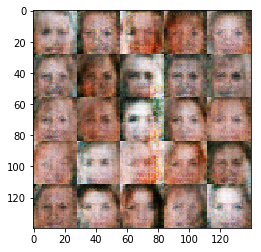

Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 2.3312
Epoch 1/1... Discriminator Loss: 0.4606... Generator Loss: 1.4657
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 2.0023
Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 1.3663
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 1.6477
Epoch 1/1... Discriminator Loss: 0.2661... Generator Loss: 3.1580
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.4224
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.8834


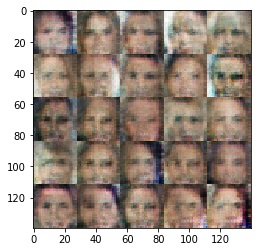

Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.5806
Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 2.4801... Generator Loss: 0.1971
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 0.4613... Generator Loss: 2.1575
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 1.8045
Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 1.7795


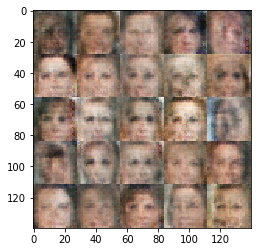

Epoch 1/1... Discriminator Loss: 0.2129... Generator Loss: 2.8036
Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 1.6492
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.8532
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 2.1341... Generator Loss: 3.5936
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.3276
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.9206... Generator Loss: 3.5216


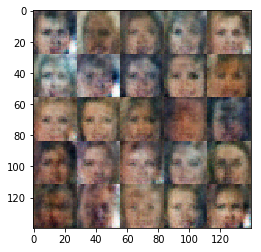

Epoch 1/1... Discriminator Loss: 0.3399... Generator Loss: 2.6897
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.6414... Generator Loss: 0.3704
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 0.4025... Generator Loss: 3.5619
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 1.6764
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.5597


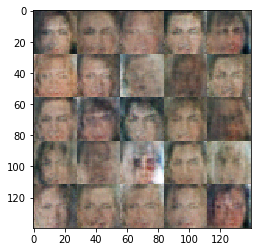

Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 2.2967
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 2.5802
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.8498
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.1678
Epoch 1/1... Discriminator Loss: 0.6472... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 1.5003
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 0.6505


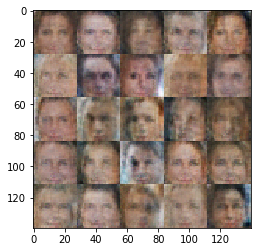

Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 2.4564
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.2525
Epoch 1/1... Discriminator Loss: 0.5242... Generator Loss: 1.6074
Epoch 1/1... Discriminator Loss: 1.6203... Generator Loss: 0.3200
Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 1.6187
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 1.5032
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 1.9498


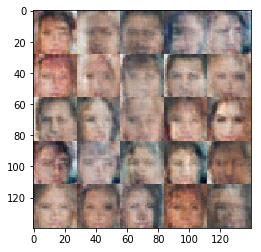

Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 1.3590
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.1341
Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 1.4086
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 0.4403... Generator Loss: 2.4240
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.4091
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 0.8641


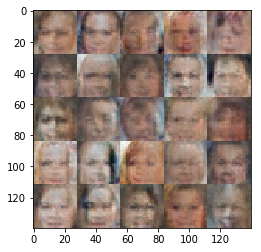

Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 2.0478
Epoch 1/1... Discriminator Loss: 0.6873... Generator Loss: 1.5666
Epoch 1/1... Discriminator Loss: 0.4245... Generator Loss: 1.7600
Epoch 1/1... Discriminator Loss: 0.5699... Generator Loss: 2.2376
Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 2.1864
Epoch 1/1... Discriminator Loss: 1.7937... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.2321
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 1.4754


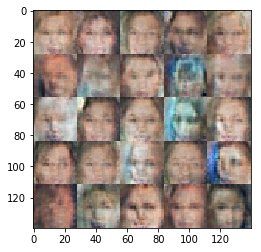

Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.4198
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.3998
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 0.6305... Generator Loss: 1.5757
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 1.4233
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.1758
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 1.7351


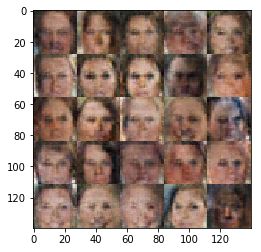

Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 1.3274
Epoch 1/1... Discriminator Loss: 0.5621... Generator Loss: 1.8561
Epoch 1/1... Discriminator Loss: 0.3645... Generator Loss: 2.9731
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.3800
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 0.6653... Generator Loss: 1.7843
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.4258
Epoch 1/1... Discriminator Loss: 0.6747... Generator Loss: 1.2911
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 0.7401


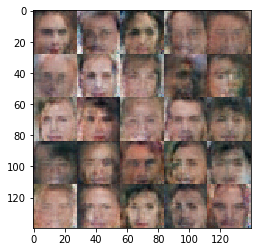

Epoch 1/1... Discriminator Loss: 0.4287... Generator Loss: 1.8683
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.5311
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.6524
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 1.8031
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.4158
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 1.5558
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 0.8906


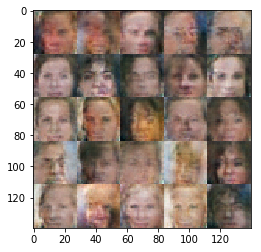

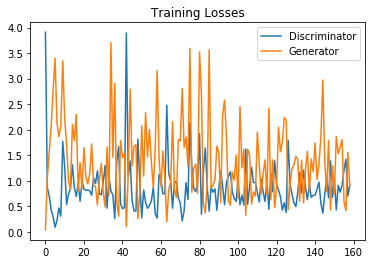

In [13]:
batch_size = 128
z_dim = 300
learning_rate = 1e-3
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.